## Settings

In [1]:
import matplotlib
#matplotlib.use('Agg')

import matplotlib.pylab as plt
import os
import sys
import argparse
import numpy as np
from PIL import Image


import argparse
import random
import os
import glob
import getpass
import datetime
import shutil
import numpy as np
import torch
from argparse import Namespace
from os import listdir
from os.path import join

from model import Model
from prediction import Prediction
from settings.training_settings import TrainingSettings as CVPPPTrainingSettings


opt= Namespace()
opt.usegpu = True
opt.debug = False
opt.nworkers = 0
opt.dataset = 'CVPPP2017'
opt.DATA_DIR = 'E:/CVPPP2017_LSC_training/images'
opt.model = 'E:/discriminative/models/UNet_CBAM_Deeper/best.pth'  # model weights after Train

model_path = opt.model
_output_path = 'E:/discriminative/models/UNet_CBAM_Deeper/Outputs2'  # inference results are saved

basepath = 'E:/CVPPP2017_LSC_training/images/val'  # path of validation image folder
image_names = sorted([join(basepath, f) for f in listdir(basepath) if f.endswith('_rgb.png')])

# can change settings at settings
ts = CVPPPTrainingSettings()

## Input Image

In [2]:
import torch.nn as nn
import numpy as np
from PIL import Image
import cv2
from sklearn.cluster import KMeans
from data.utils import ImageUtilities
from modules.coord_conv import AddCoordinates
import torchvision.transforms as transforms


normalizer = ImageUtilities.image_normalizer(mean=[0,0,0], std=[1,1,1])
use_coordinates = True
resize_height = 256
resize_width = 256
img_resizer = ImageUtilities.image_resizer(resize_height, resize_width)
coordinate_adder = AddCoordinates(with_r=True, usegpu=False)

C:\Users\Moon\Anaconda3\envs\iml\lib\site-packages\torchvision\transforms\transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [3]:
def get_image(image_path):

    img = ImageUtilities.read_image(image_path)  # open image as PIL RGB
    image_width, image_height = img.size

    img = img_resizer(img)
    img = normalizer(img)  # PIL to Tensor actually

    return img, image_height, image_width

In [4]:
image_name = image_names[0]
image, image_height, image_width = get_image('E:/CVPPP2017_LSC_training/images/A1/plant132_rgb.png')
image = image.unsqueeze(0)

image = image.contiguous()

print(image.shape)

torch.Size([1, 3, 256, 256])


## Define Model

In [5]:
from networks.unet_cbam import UNet_CBAM_Deeper

model = UNet_CBAM_Deeper()
model = model.cuda()

model_state_dict = model.state_dict()
pretrained_state_dict = torch.load('E:/discriminative/models/Ex_CBAM3/best.pth')
model_state_dict.update(pretrained_state_dict)
model.load_state_dict(model_state_dict)

for param in model.parameters():
    param.requires_grad = False
    
model.eval()

UNet_CBAM_Deeper(
  (inc): inconv(
    (conv): double_conv(
      (conv): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
      (cbam): CBAM(
        (ChannelGate): ChannelGate(
          (mlp): Sequential(
            (0): Flatten()
            (1): Linear(in_features=64, out_features=4, bias=True)
            (2): ReLU()
            (3): Linear(in_features=4, out_features=64, bias=True)
          )
        )
        (SpatialGate): SpatialGate(
          (compress): ChannelPool()
          (spatial): BasicConv(
            (conv): Conv2d(2, 1, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
       

In [9]:
from torch.autograd import Variable

def __define_variable(tensor, volatile=False):
    if volatile:
        with torch.no_grad():
            return Variable(tensor)

    return Variable(tensor)

images = image.contiguous()
images = __define_variable(images, volatile=True)

images = images.cuda()

## Get prediction

In [30]:
sem_seg_predictions, ins_seg_predictions, n_objects_predictions = model(images)
print(sem_seg_predictions.shape)
print(ins_seg_predictions.shape)
print(n_objects_predictions)

C:\Users\Moon\Anaconda3\envs\iml\lib\site-packages\torch\nn\functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


torch.Size([1, 2, 256, 256])
torch.Size([1, 32, 256, 256])
tensor([[0.8062]], device='cuda:0')


In [31]:
sem_seg_predictions = torch.nn.functional.softmax(sem_seg_predictions, dim=1)  # apply softmax

n_objects_predictions = n_objects_predictions * 20
n_objects_predictions = torch.round(n_objects_predictions).int()

sem_seg_predictions = sem_seg_predictions.data.cpu()  # (1, 2, 256, 256)
ins_seg_predictions = ins_seg_predictions.data.cpu()  # (1, 32, 256, 256)
n_objects_predictions = n_objects_predictions.data.cpu()  # ([N], dtype=torch.int32)

sem_seg_prediction = sem_seg_predictions.squeeze(0)  # (2, 256, 256)
ins_seg_prediction = ins_seg_predictions.squeeze(0)  # (32, 256, 256)
n_objects_prediction = n_objects_predictions.squeeze(0)  # ([N], dtype=torch.int32)

In [32]:
# normalized values
# https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.imshow.html
print(torch.max(ins_seg_prediction.flatten()))
print(torch.min(ins_seg_prediction.flatten()))  

tensor(1.7494)
tensor(-1.8716)


## Visualize Semantic Mask & Embeddings

In [33]:
seg_height, seg_width = ins_seg_prediction.shape[1:]

sem_seg_prediction = sem_seg_prediction.cpu().numpy()
sem_seg_prediction = sem_seg_prediction.argmax(0).astype(np.uint8)  # (256, 256)

embeddings = ins_seg_prediction.cpu()  # (32, 256, 256) - piexel values are double

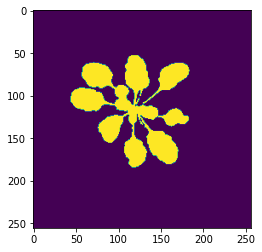

In [34]:
import matplotlib.pyplot
import cv2

plt.imshow(sem_seg_prediction)
plt.show()

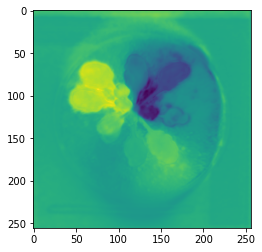

In [35]:
plt.imshow(embeddings[0])

## Visualize all 32 dims Embeddings

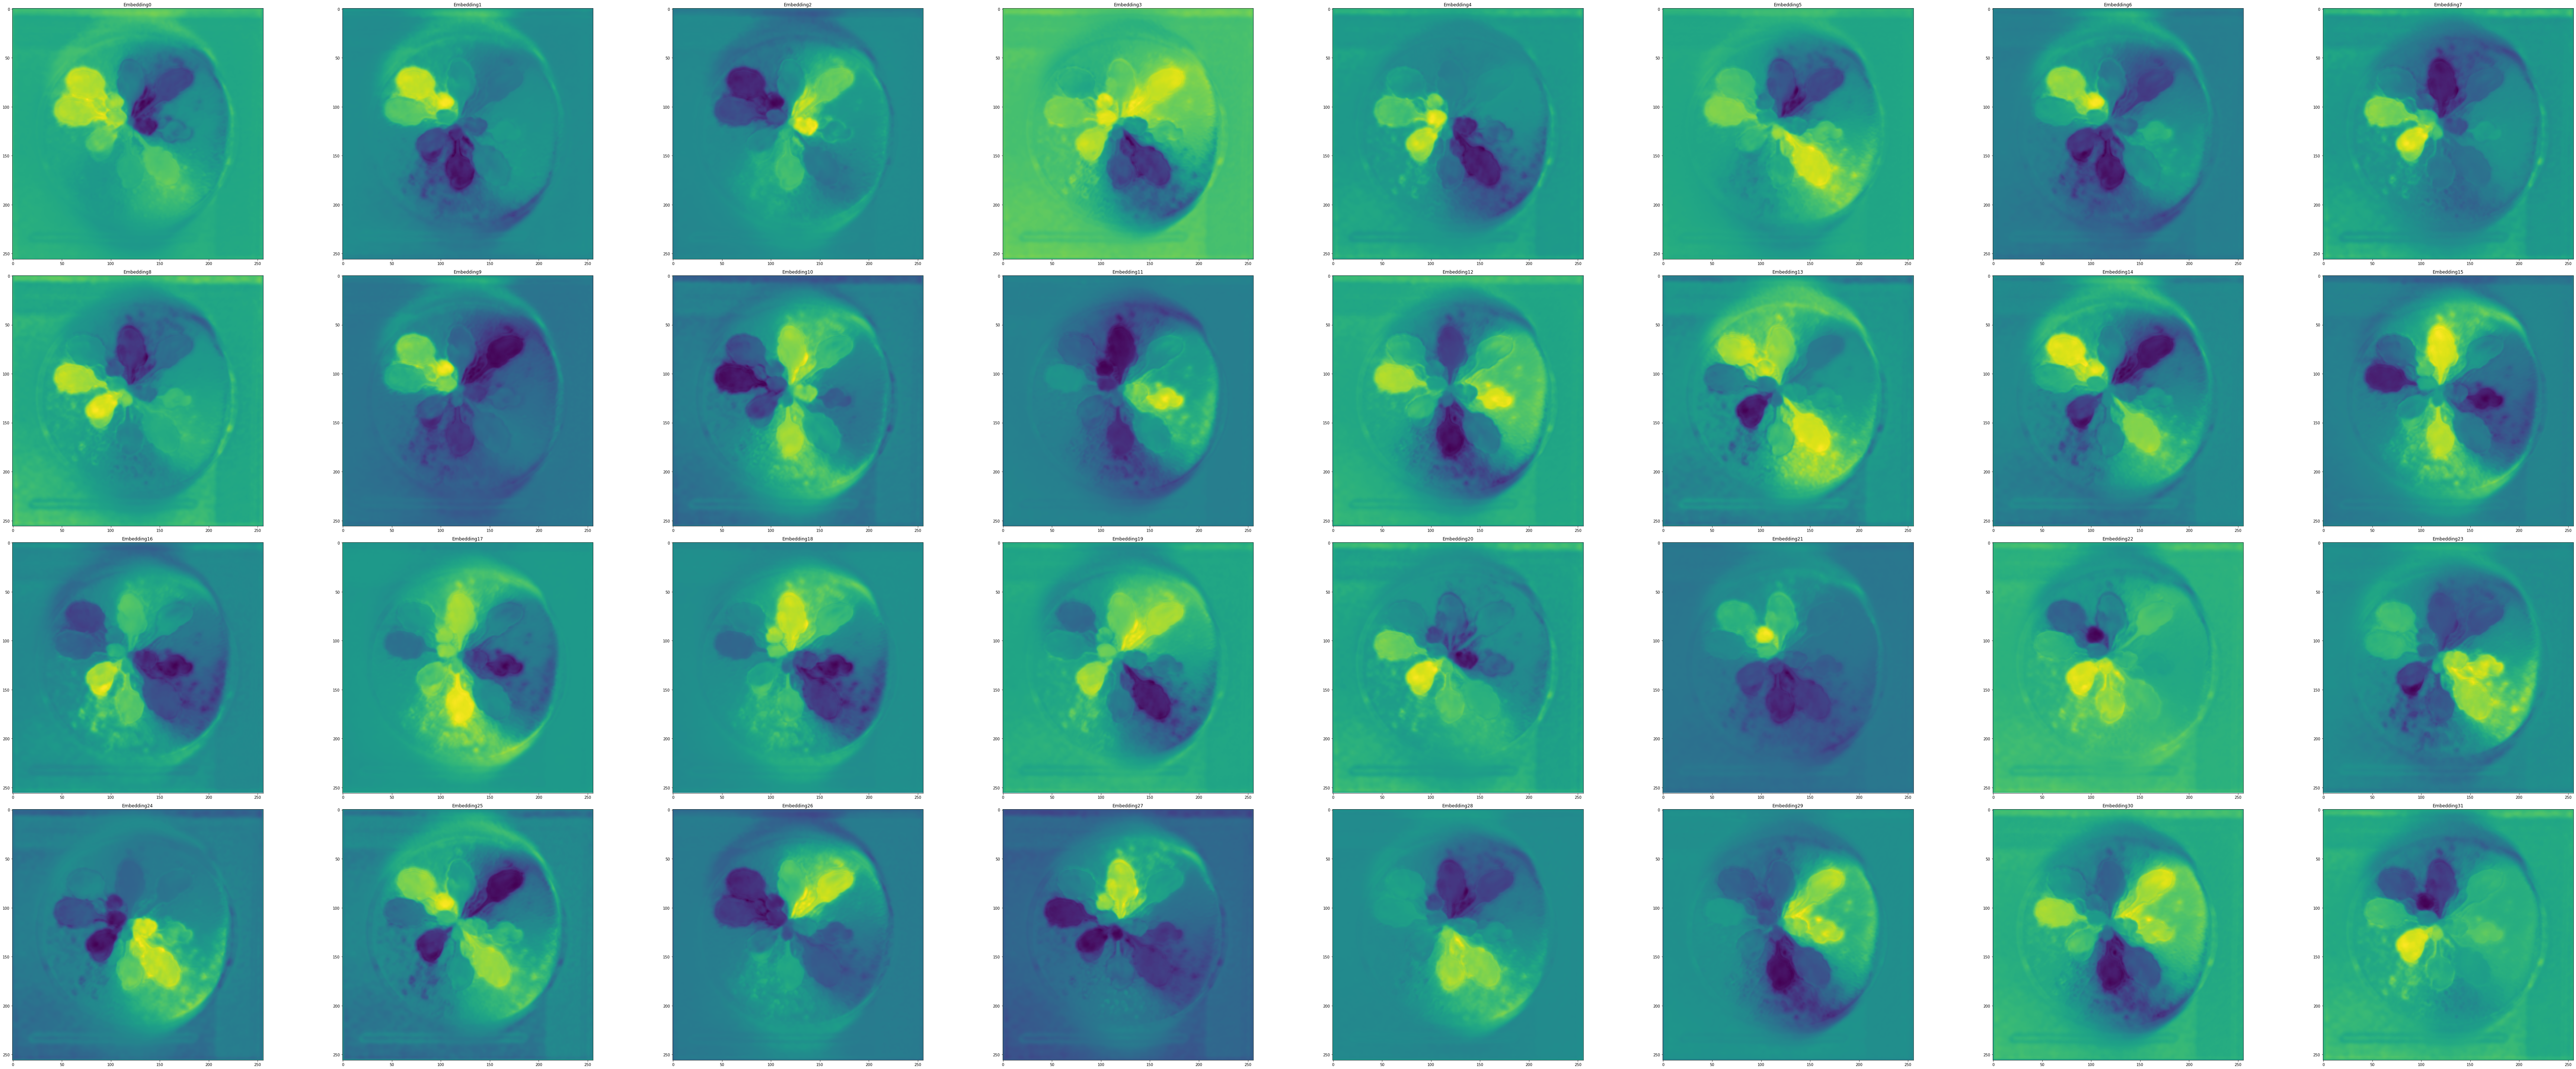

In [36]:
rows = 4
cols = 8
axes = []
fig = plt.figure(figsize=(100, 40))

for a in range(rows * cols):
    b = embeddings[a]
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = ("Embedding" + str(a))
    axes[-1].set_title(subplot_title)  
    plt.imshow(b)
    
fig.tight_layout()    
plt.show()

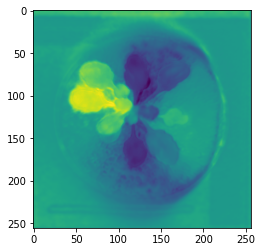

In [37]:
total_embedding = torch.zeros([256, 256])
for i in range(embeddings.shape[0]-20):
    embedding = embeddings[i]
    total_embedding += embedding
    
plt.imshow(total_embedding)

## Post-Processing of Embeddings

In [38]:
embeddings = embeddings.unsqueeze(0)  # (1, 32, 256, 256)

embeddings = embeddings.numpy()
embeddings = embeddings.squeeze(0)  # (32, 256, 256)
embeddings = embeddings.transpose(1, 2, 0)  # (256, 256, 32)

n_objects_prediction = n_objects_prediction.cpu().numpy()[0]
print(n_objects_prediction)

16


In [39]:
from scipy import ndimage as ndi
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN

# embeddings[:, :, i][sem_seg_prediction != 0] + embeddings[:, :, i][sem_seg_prediction == 0] = h x w
embeddings_stacked = np.stack([embeddings[:, :, i][sem_seg_prediction != 0]
                               for i in range(embeddings.shape[2])], axis=1)  

print(embeddings_stacked.shape)  # (n_samples, n_features) - similar to DataFrame

(7645, 32)


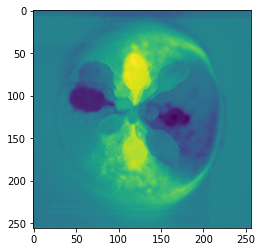

In [40]:
plt.imshow(embeddings[:, :, 15])

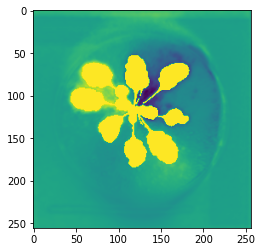

In [41]:
a = embeddings[:, :, 0].copy()

instance_mask = np.zeros((seg_height, seg_width), dtype=np.uint8)

fg_coords = np.where(sem_seg_prediction != 0)
for si in range(len(fg_coords[0])):
    y_coord = fg_coords[0][si]
    x_coord = fg_coords[1][si]
    
    a[y_coord, x_coord] = 1
    
plt.imshow(a)

# from each embeddings, pixel values of 'yellow area'(RoI of semantic mask) are extracted
# in this case, 7645 points of fixed locations are extracted

## Clustering & Colorization

In [42]:
labels = KMeans(n_clusters=n_objects_prediction, 
                n_init=35, max_iter=500).fit_predict(embeddings_stacked)  
print(np.unique(labels))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]


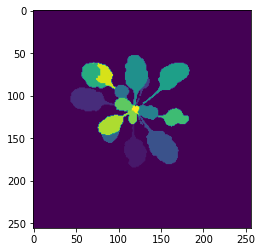

In [43]:
instance_mask = np.zeros((seg_height, seg_width), dtype=np.uint8)

fg_coords = np.where(sem_seg_prediction != 0)
for si in range(len(fg_coords[0])):
    y_coord = fg_coords[0][si]
    x_coord = fg_coords[1][si]
    
    _label = labels[si] + 1
    instance_mask[y_coord, x_coord] = _label
    
plt.imshow(instance_mask)
plt.show()

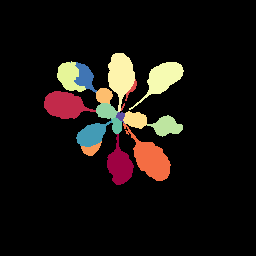

In [44]:
fg_seg_pred = sem_seg_prediction
ins_seg_pred = instance_mask
n_objects_pred = n_objects_prediction

_n_clusters = len(np.unique(ins_seg_pred.flatten())) - 1  # discard bg
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, _n_clusters)]
ins_seg_pred_color = np.zeros(
        (ins_seg_pred.shape[0], ins_seg_pred.shape[1], 3), dtype=np.uint8)
for i in range(_n_clusters):
    ins_seg_pred_color[ins_seg_pred == (
        i + 1)] = (np.array(colors[i][:3]) * 255).astype('int')
    
ins_seg_pred_color_pil = Image.fromarray(ins_seg_pred_color)
ins_seg_pred_color_pil